#Лабораторна робота №1. Попередня обробка даних і побудова навчальних наборів


**Виконала** студентка групи КІ-41мп Додонова Марія.

**Мета:** Виконати попередню обробку даних відповідно до уроку U-2.

##Порядок виконання

0. Опрацювати матеріали уроку U-2.
1. Обрати набір даних з категоріальними ознаками.
2. Виконати обробку категоріальних даних:
  - відобразити номінальні ознаки за допомогою pandas,
  - кодувати мітки класів,
  - зробити оne-hot кодування номінальних ознак,
  - виконати кодування порядкових ознак (за їх наявності).
3. Обрати великий набір даних з відсутніми значеннями. 2K прикладів у наборі буде достатньо.
Набір можна сформувати самостійно випадково вилучаючи по одному значенню з кожного рядка наборів fetch_california_housing або load_diabetes з sklearn.datasets.
4. Заповнити відсутні значення шляхом інтерполяції:
   - алгоритмом KNNImputer з sklearn.impute,   
   - одновимірним алгоритмом SimpleImputer з sklearn.impute,
   - багатовимірним алгоритмом IterativeImputer з sklearn.impute.
5. Розглянути різні значення параметрів алгоритмів SimpleImputer та IterativeImputer:
   - параметрів strategy в SimpleImputer та initial_strategy в IterativeImputer, а також інших параметрів в якості експеримента,
   - параметра estimator в IterativeImputer.
Наприклад, параметр estimator може приймати значення: BayesianRidge, RandomForestRegressor, KNeighborsRegressor.
6. Побудувати конвеєр з оцінщиків, використовуючи sklearn.pipeline.make_pipeline.
7. Порівняти результати за різними алгоритмами та при різних значеннях їх параметрів. Показником якості (score) обрати, наприклад, MSE.
Побудувати графік/діаграму значень показника якості для різних алгоритмів заповнення (та різних наборів значень параметрів цих алгоритмів).
8. Зробити висновки. Обрати найкращий алгоритм для заповнення пропусків у ваших даних.

##Виконання роботи

###Обрати набір даних з категоріальними ознаками.

Оберемо набір даних Mushroom Dataset (UCI), який містить 18 номінальних ознак, 4 порядкові ознаки та цільову змінну, що є номінальною.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/mushroom-classification")

print("Path to dataset files:", path)

100%|██████████| 34.2k/34.2k [00:00<00:00, 20.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/mushroom-classification/versions/1


In [ ]:
import pandas as pd
import os

datafile = os.path.join(path, "mushrooms.csv")
df = pd.read_csv(datafile)
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [ ]:
target_variable = 'class'

ordinal_features = [
    'gill-spacing', 'gill-size', 'ring-number', 'population'
]

nominal_features = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-color', 'stalk-shape', 'stalk-root',
    'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
    'veil-color', 'ring-type', 'spore-print-color', 'habitat'
]

features = ordinal_features + nominal_features

###Виконати обробку категоріальних даних

Відобразимо порядкові ознаки за допомогою pandas.

In [ ]:
# gill-spacing: distant (d) < close (c) < crowded (w)
gill_spacing_mapping = {'d': 1, 'c': 2, 'w': 3}
df['gill-spacing'] = df['gill-spacing'].map(gill_spacing_mapping)

# gill-size: narrow (n) < broad (b)
gill_size_mapping = {'n': 1, 'b': 2}
df['gill-size'] = df['gill-size'].map(gill_size_mapping)

# ring-number: none (n) < one (o) < two (t)
ring_number_mapping = {'n': 0, 'o': 1, 't': 2}
df['ring-number'] = df['ring-number'].map(ring_number_mapping)

# population: solitary (y) < several (v) < scattered (s) < numerous (n) <
#             < clustered (c) < abundant (a)
population_mapping = {'y': 1, 'v': 2, 's': 3, 'n': 4, 'c': 5, 'a': 6}
df['population'] = df['population'].map(population_mapping)

df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,2,1,k,...,s,w,w,p,w,1,p,k,3,u
1,e,x,s,y,t,a,f,2,2,k,...,s,w,w,p,w,1,p,n,4,g
2,e,b,s,w,t,l,f,2,2,n,...,s,w,w,p,w,1,p,n,4,m
3,p,x,y,w,t,p,f,2,1,n,...,s,w,w,p,w,1,p,k,3,u
4,e,x,s,g,f,n,f,3,2,k,...,s,w,w,p,w,1,e,n,6,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,2,2,y,...,s,o,o,p,o,1,p,b,5,l
8120,e,x,s,n,f,n,a,2,2,y,...,s,o,o,p,n,1,p,b,2,l
8121,e,f,s,n,f,n,a,2,2,n,...,s,o,o,p,o,1,p,b,5,l
8122,p,k,y,n,f,y,f,2,1,b,...,k,w,w,p,w,1,e,w,2,l


Виконаємо кодування міток класів.

In [ ]:
import numpy as np

class_mapping = {
    label: idx
    for idx, label in enumerate(np.unique(df[target_variable]))
}

df[target_variable] = df[target_variable].map(class_mapping)
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,t,p,f,2,1,k,...,s,w,w,p,w,1,p,k,3,u
1,0,x,s,y,t,a,f,2,2,k,...,s,w,w,p,w,1,p,n,4,g
2,0,b,s,w,t,l,f,2,2,n,...,s,w,w,p,w,1,p,n,4,m
3,1,x,y,w,t,p,f,2,1,n,...,s,w,w,p,w,1,p,k,3,u
4,0,x,s,g,f,n,f,3,2,k,...,s,w,w,p,w,1,e,n,6,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,k,s,n,f,n,a,2,2,y,...,s,o,o,p,o,1,p,b,5,l
8120,0,x,s,n,f,n,a,2,2,y,...,s,o,o,p,n,1,p,b,2,l
8121,0,f,s,n,f,n,a,2,2,n,...,s,o,o,p,o,1,p,b,5,l
8122,1,k,y,n,f,y,f,2,1,b,...,k,w,w,p,w,1,e,w,2,l


Альтернативним способом кодування міток класів може бути виконане за допомогою LabelEncoder.

In [ ]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df[target_variable].values)
y

array([1, 0, 0, ..., 0, 1, 0])

Зробимо one-hot кодування номінальних ознак за допомогою pandas зі скороченням взаємозв'язку між ознаками.

In [ ]:
pd.get_dummies(df[features], drop_first=True, prefix_sep='-', dtype=int)

,gill-spacing,gill-size,ring-number,population,cap-shape-c,cap-shape-f,cap-shape-k,cap-shape-s,cap-shape-x,cap-surface-g,...,spore-print-color-r,spore-print-color-u,spore-print-color-w,spore-print-color-y,habitat-g,habitat-l,habitat-m,habitat-p,habitat-u,habitat-w
0,2,1,1,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2,2,1,4,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,2,2,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2,1,1,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,3,2,1,6,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2,2,1,5,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,2,2,1,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8121,2,2,1,5,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,2,1,1,2,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


Альтернативний метод one-hot кодування номінальних ознак використовує ColumnTransformer та OneHotEncoder.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df[features].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), list(range(4, 22))),
    ('nothing', 'passthrough', [0, 1, 2, 3])
])
c_transf.fit_transform(X).astype(int).toarray()

array([[0, 0, 0, ..., 1, 1, 3],
       [0, 0, 0, ..., 2, 1, 4],
       [0, 0, 0, ..., 2, 1, 4],
       ...,
       [0, 1, 0, ..., 2, 1, 5],
       [0, 0, 1, ..., 1, 1, 2],
       [0, 0, 0, ..., 2, 1, 5]])

Виконаємо порогове кодування порядкових ознак.

In [ ]:
df = pd.read_csv(datafile)
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [ ]:
# gill-spacing: distant (d) < close (c) < crowded (w)
df['gill-spacing > d'] = df['gill-spacing'].apply(lambda x: 1 if x in {'c', 'w'} else 0)
df['gill-spacing > c'] = df['gill-spacing'].apply(lambda x: 1 if x == 'w' else 0)
del df['gill-spacing']

# gill-size: narrow (n) < broad (b)
df['gill-size > n'] = df['gill-size'].apply(lambda x: 1 if x == 'b' else 0)
del df['gill-size']

# ring-number: none (n) < one (o) < two (t)
ring_number_mapping = {'n': 0, 'o': 1, 't': 2}
df['ring-number > n'] = df['ring-number'].apply(lambda x: 1 if x in {'o', 't'} else 0)
df['ring-number > o'] = df['ring-number'].apply(lambda x: 1 if x == 't' else 0)
del df['ring-number']

# population: solitary (y) < several (v) < scattered (s) < numerous (n) < clustered (c) < abundant (a)
df['population > y'] = df['population'].apply(lambda x: 1 if x in {'v', 's', 'n', 'c', 'a'} else 0)
df['population > v'] = df['population'].apply(lambda x: 1 if x in {'s', 'n', 'c', 'a'} else 0)
df['population > s'] = df['population'].apply(lambda x: 1 if x in {'n', 'c', 'a'} else 0)
df['population > n'] = df['population'].apply(lambda x: 1 if x in {'c', 'a'} else 0)
df['population > c'] = df['population'].apply(lambda x: 1 if x == 'a' else 0)
del df['population']

df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-color,stalk-shape,stalk-root,...,gill-spacing > d,gill-spacing > c,gill-size > n,ring-number > n,ring-number > o,population > y,population > v,population > s,population > n,population > c
0,p,x,s,n,t,p,f,k,e,e,...,1,0,0,1,0,1,1,0,0,0
1,e,x,s,y,t,a,f,k,e,c,...,1,0,1,1,0,1,1,1,0,0
2,e,b,s,w,t,l,f,n,e,c,...,1,0,1,1,0,1,1,1,0,0
3,p,x,y,w,t,p,f,n,e,e,...,1,0,0,1,0,1,1,0,0,0
4,e,x,s,g,f,n,f,k,t,e,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,y,e,?,...,1,0,1,1,0,1,1,1,1,0
8120,e,x,s,n,f,n,a,y,e,?,...,1,0,1,1,0,1,0,0,0,0
8121,e,f,s,n,f,n,a,n,e,?,...,1,0,1,1,0,1,1,1,1,0
8122,p,k,y,n,f,y,f,b,t,?,...,1,0,0,1,0,1,0,0,0,0


Слід зауважити, що порогове кодування є доцільним для ознак gill-spacing, gill-size та population, оскільки не існує чіткої числової різниці між катеогріями цих порядкових ознак. У випадку порядкової ознаки ring-number доцільніше використати відображення, оскільки значення, які вона може мати, відображають чітку числову кількість: 0, 1 або 2.

###Обрати великий набір даних з відсутніми значеннями.

Сформуємо набір (2К прикладів) випадково вилучаючи по одному значенню з кожного рядка набору fetch_california_housing з sklearn.datasets.

In [ ]:
from sklearn.datasets import fetch_california_housing

rng = np.random.RandomState(42)

X_full, y_full = fetch_california_housing(return_X_y=True)
X_full, y_full = X_full[:2000], y_full[:2000]
n_samples, n_features = X_full.shape

X_missing, y_missing = X_full.copy(), y_full.copy()
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

X_missing

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
                  nan, -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [          nan,   45.        ,    4.7       , ...,    3.56956522,
          36.73      , -119.77      ],
       [   1.5227    ,   39.        ,    4.20588235, ...,    4.52941176,
                  nan, -119.77      ],
       [          nan,   20.        ,    4.18735892, ...,    2.46275395,
          36.74      , -119.77      ]])

###Заповнити відсутні значення шляхом інтерполяції

Заповнимо відсутні значення шляхом інтерполяції алгоритмом KNNImputer з sklearn.impute. Додамо індикаторний стовпець для індикації ознак, що містили пропуски.

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
imputed_data = imputer.fit_transform(X_missing)
print(imputed_data[:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78460000e+01 -1.22230000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  1.02004894e+00
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   8.98600000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00

Заповнимо відсутні значення шляхом інтерполяції одновимірним алгоритмом SimpleImputer з sklearn.impute. Заповнюватимемо пропуски середнім значенням кожної ознаки. Додамо також індикаторний стовпець для індикації ознак, що містили пропуски.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(
    missing_values=np.nan, strategy="mean", add_indicator=True
)
imputed_data = imputer.fit_transform(X_missing)
print(imputed_data[:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.80696524e+01 -1.22230000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  1.15659284e+00
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   1.23657421e+03  2.80225989e+00  3.78500000e+01 -1.22240000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.80696524e+01 -1.22250000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00

Заповнимо відсутні значення шляхом інтерполяції багатовимірним алгоритмом IterativeImputer з sklearn.impute. Для прогнозування пропущених значень використовуватимемо 3 найближчих ознаки та максимальну кількість ітерацій 10. Додамо також індикаторний стовпець для індикації ознак, що містили пропуски.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(
    missing_values=np.nan, sample_posterior=True, n_nearest_features=3,
    max_iter=10, random_state=0, add_indicator=True
)
imputed_data = imputer.fit_transform(X_missing)
print(imputed_data[:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.80161003e+01 -1.22230000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  6.55116054e+00
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
  -4.79245700e+03  2.80225989e+00  3.78500000e+01 -1.22240000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.86617680e+01 -1.22250000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00

###Побудувати конвеєр з оцінщиків, використовуючи sklearn.pipeline.make_pipeline.

Побудуємо конвеєр з оцінщиків, використовуючи sklearn.pipeline.make_pipeline. Показником якості (score) оберемо MSE. Обчислюватимемо середнє значення та стандартне відхилення MSE для 4 фолдів кросс-валідації. Повертатимемо негативне значення scores.mean(), оскільки для забезпечення правильної роботи cross_val_score() використовувалось негативне значення MSE.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

regressor = RandomForestRegressor(random_state=0)

def evaluate_imputer(imputer, X_missing, y_missing):
  estimator = make_pipeline(imputer, regressor)
  scores = cross_val_score(
      estimator, X_missing, y_missing,
      scoring="neg_mean_squared_error", cv=4
  )
  return -scores.mean(), scores.std()

###Розглянути різні значення параметрів алгоритмів SimpleImputer та IterativeImputer

Розглянемо різні значення параметра startegy в SimpleImputer, а саме значення "mean", "median" та "most_frequent". Зберігатимемо результати та назви вимірювань у масиви labels, mses та stds.

In [ ]:
labels, mses, stds = [], [], []

In [ ]:
for strategy in ["mean", "median", "most_frequent"]:
  imputer = SimpleImputer(
      missing_values=np.nan, strategy=strategy, add_indicator=True
  )
  mse, std = evaluate_imputer(imputer, X_missing, y_missing)
  label = f"SimpleImputer (strategy={strategy})"
  labels.append(label)
  mses.append(mse)
  stds.append(std)
  print(f"{label} MSE: mean: {mse:.4f}, std: {std:.4f}")

SimpleImputer (strategy=mean) MSE: mean: 0.3777, std: 0.1304
SimpleImputer (strategy=median) MSE: mean: 0.3699, std: 0.1241
SimpleImputer (strategy=most_frequent) MSE: mean: 0.3659, std: 0.1148


Розглянемо різні значення параметра initial_startegy в IterativeImputer, а саме значення "mean", "median" та "most_frequent". Використовуватимемо 3 найближчих ознаки та максимальну кількість ітерацій 10.

In [ ]:
for initial_strategy in ["mean", "median", "most_frequent"]:
  imputer = IterativeImputer(
      missing_values=np.nan, sample_posterior=True, n_nearest_features=3,
      initial_strategy=initial_strategy, max_iter=10, random_state=0,
      add_indicator=True
  )
  mse, std = evaluate_imputer(imputer, X_missing, y_missing)
  label = f"IterativeImputer (initial_strategy={initial_strategy})"
  labels.append(label)
  mses.append(mse)
  stds.append(std)
  print(f"{label} MSE: mean: {mse:.4f}, std: {std:.4f}")

IterativeImputer (initial_strategy=mean) MSE: mean: 0.3884, std: 0.1021
IterativeImputer (initial_strategy=median) MSE: mean: 0.3888, std: 0.1049
IterativeImputer (initial_strategy=most_frequent) MSE: mean: 0.3937, std: 0.0844


Розглянемо різні значення параметра estimator в IterativeImputer, а саме BayesianRidge, RandomForestRegressor та KNeighborsRegressor. Використовуватимемо максимальну кількість ітерацій 10 та стратегію заповнення "mean".

Для RandomForestRegressor використаємо 4 дерева, максимальну глибину 10, а кожне дерево будуватимемо на половині вибірки.

Кількість сусідів для KNeighborsRegressor встановимо 15.

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        n_estimators=4, max_depth=10, bootstrap=True,
        max_samples=0.5, random_state=0
    ),
    KNeighborsRegressor(n_neighbors=15)
]

for estimator in estimators:
  imputer = IterativeImputer(
      random_state=0, estimator=estimator, max_iter=10
  )
  mse, std = evaluate_imputer(imputer, X_missing, y_missing)
  estimator_name = estimator.__class__.__name__
  label = f"IterativeImputer (estimator={estimator_name})"
  labels.append(label)
  mses.append(mse)
  stds.append(std)
  print(f"{label} MSE: mean: {mse:.4f}, std: {std:.4f}")

IterativeImputer (estimator=BayesianRidge) MSE: mean: 0.3877, std: 0.0964
IterativeImputer (estimator=RandomForestRegressor) MSE: mean: 0.3628, std: 0.1098
IterativeImputer (estimator=KNeighborsRegressor) MSE: mean: 0.3859, std: 0.1335


Розглянемо різні значення параметрів max_iter та n_nearest_features в IterativeImputer. Використовуватимемо початкову стратегію "mean".

In [ ]:
for max_iter in [1, 10, 20]:
  imputer = IterativeImputer(
      missing_values=np.nan, sample_posterior=True, n_nearest_features=3,
      max_iter=max_iter, random_state=0, add_indicator=True
  )
  mse, std = evaluate_imputer(imputer, X_missing, y_missing)
  label = f"IterativeImputer (max_iter={max_iter})"
  labels.append(label)
  mses.append(mse)
  stds.append(std)
  print(f"{label} MSE: mean: {mse:.4f}, std: {std:.4f}")

IterativeImputer (max_iter=1) MSE: mean: 0.4003, std: 0.1171
IterativeImputer (max_iter=10) MSE: mean: 0.3884, std: 0.1021
IterativeImputer (max_iter=20) MSE: mean: 0.4033, std: 0.1225


In [ ]:
for n_nearest_features in [1, 3, 5]:
  imputer = IterativeImputer(
      missing_values=np.nan, sample_posterior=True,
      n_nearest_features=n_nearest_features, max_iter=10,
      random_state=0, add_indicator=True
  )
  mse, std = evaluate_imputer(imputer, X_missing, y_missing)
  label = f"IterativeImputer (n_nearest_features={n_nearest_features})"
  labels.append(label)
  mses.append(mse)
  stds.append(std)
  print(f"{label} MSE: mean: {mse:.4f}, std: {std:.4f}")

IterativeImputer (n_nearest_features=1) MSE: mean: 0.4230, std: 0.1084
IterativeImputer (n_nearest_features=3) MSE: mean: 0.3884, std: 0.1021
IterativeImputer (n_nearest_features=5) MSE: mean: 0.4036, std: 0.1164


###Порівняти результати за різними алгоритмами та при різних значеннях їх параметрів.

Побудуємо діаграму значень MSE для різних алгоритмів заповнення та різних наборів значень параметрів цих алгоритмів.

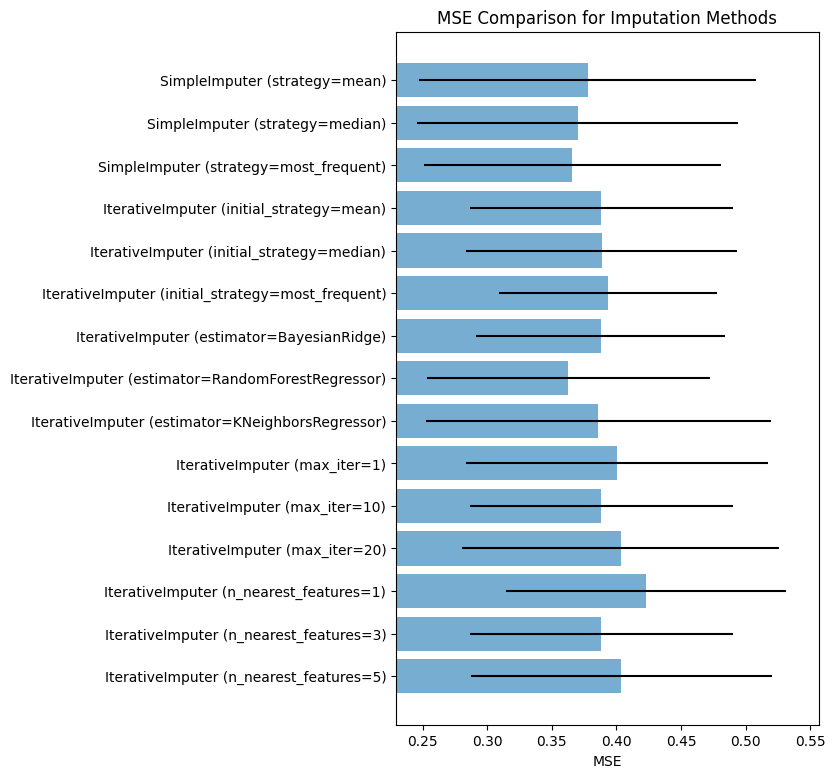

In [ ]:
import matplotlib.pyplot as plt

xval = np.arange(len(mses))

plt.figure(figsize=(12, 9))
ax1 = plt.subplot(121)

ax1.barh(
    xval, mses, xerr=stds, color=None, alpha=0.6, align="center"
)

ax1.set_title("MSE Comparison for Imputation Methods")
left_lim = (min(mses) - max(stds))
right_lim = (max(mses) + max(stds))
ax1.set_xlim(left_lim, right_lim)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(labels)

plt.show()

##Висновок

У ході роботи було досліджено різні алгоритми заповнення пропущених значень у даних датасету fetch_california_housing. Було випробувано методи SimpleImputer та IterativeImputer з різними параметрами та оцінено їх ефективність за показником MSE.

Найкращим алгоритмом для заповнення пропусків виявився IterativeImputer із використанням RandomForestRegressor як естіматора (середнє значення MSE: 0.3628, стандартне відхилення: 0.1098).

Також хороші результати продемонстрував SimpleImputer зі стратегією "most_frequent", який показав найнижче середнє значення MSE, що становило 0.3659, зі стандартним відхиленням 0.1148.

## Джерела даних
Mushrooms Dataset отримано з Kaggle:  
https://www.kaggle.com/datasets/uciml/mushroom-classification.

California Housing Dataset:  
https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset.